## Notebook Description
### Model Four
This notebook is dedicated to my fourth model, which uses data from `engineered_data` folder. The model runs the `title_merge` column through the `CountVectorize`, before running through a `Random Forest` model. Resulting in an Accuracy Score of 0.919

In [25]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve

In [26]:
# This file path SHOULD throw an error, but I can't get it to and I have no clue why! Other models use this exact file, and are stored in this same folder,
# and use a different file path. If I try `../engineered_data...` here, it will throw an error - no clue why!

df = pd.read_csv('../engineered_data/engineered_data_merged_columns.csv')
df.head()

,subreddit,created_utc,title_merge,title_sentiment_neg,title_sentiment_neu,title_sentiment_pos,title_sentiment_compound,title_length,title_word_count,capitalized_letters_in_title,sentences_in_title
0,backpacking,1646011972,"Where to backpack 4 nights in Utah, Arizona, o...",0.000,0.804,0.196,0.9127,315,60,16,4
1,backpacking,1646007041,"Peace Walls, Belfast",0.000,0.364,0.636,0.5423,21,4,3,0
2,backpacking,1646005307,How To Mount Snowshoes On Osprey Talon 22 Back...,0.000,0.760,0.240,0.9282,247,45,11,5
3,backpacking,1646004876,Bringing dog to Kearsarge pass? [removed],0.000,1.000,0.000,0.0000,41,6,2,1
4,backpacking,1646000495,Mid 30s short trip to Thailand - Bangkok &amp;...,0.024,0.787,0.189,0.9786,839,162,32,11


#### Baseline Model

In [27]:
# Baseline model
# Need my model to be better than .50

df['subreddit'].value_counts(normalize=True)

ultrarunning    0.500125
backpacking     0.499875
Name: subreddit, dtype: float64

#### Set Up Target Variable

In [28]:
df['subreddit'] = df['subreddit'].replace({'ultrarunning': 0, 'backpacking': 1})
df.head()

,subreddit,created_utc,title_merge,title_sentiment_neg,title_sentiment_neu,title_sentiment_pos,title_sentiment_compound,title_length,title_word_count,capitalized_letters_in_title,sentences_in_title
0,1,1646011972,"Where to backpack 4 nights in Utah, Arizona, o...",0.000,0.804,0.196,0.9127,315,60,16,4
1,1,1646007041,"Peace Walls, Belfast",0.000,0.364,0.636,0.5423,21,4,3,0
2,1,1646005307,How To Mount Snowshoes On Osprey Talon 22 Back...,0.000,0.760,0.240,0.9282,247,45,11,5
3,1,1646004876,Bringing dog to Kearsarge pass? [removed],0.000,1.000,0.000,0.0000,41,6,2,1
4,1,1646000495,Mid 30s short trip to Thailand - Bangkok &amp;...,0.024,0.787,0.189,0.9786,839,162,32,11


In [29]:
# Create X and Y for CountVectorizer

X = df['title_merge']
y = df['subreddit']

In [30]:
# Train/Test/Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#### CountVectorizer

In [31]:
pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('model', RandomForestClassifier())
])

In [32]:
param_grid = {
    'model__n_estimators': [100, 300, 500, 800, 1200],
}
gs = GridSearchCV(pipe,
                  param_grid=param_grid,
                  verbose=1,
                  scoring='accuracy'
                 )
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.9186388425153034


{'model__n_estimators': 300}

### Evaluations

In [33]:
gs.score(X_train, y_train)

0.9996665555185061

In [34]:
gs.score(X_test, y_test)

0.921

#### Predictions

In [35]:
preds = gs.predict(X_test)
preds[:10]

array([1, 0, 1, 0, 0, 0, 1, 1, 1, 0])

#### Model Evaluation

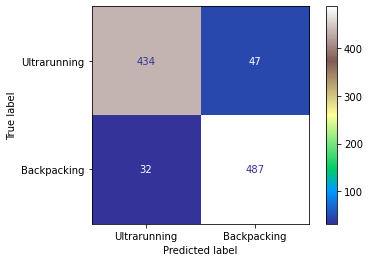

In [36]:
plot_confusion_matrix(gs, X_test, y_test, cmap='terrain', display_labels=['Ultrarunning', 'Backpacking'])
plt.savefig("../graphics/model_four_rf_confusion_matrix.jpg", bbox_inches="tight", dpi=100); #save as jpg

In [37]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

print(f'TN = {tn}')
print(f'FP = {fp}')
print(f'FN = {fn}')
print(f'TP = {tp}')

TN = 434
FP = 47
FN = 32
TP = 487


In [38]:
metrics.accuracy_score(y_test, preds)

0.921

In [39]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.93      0.90      0.92       481
           1       0.91      0.94      0.92       519

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



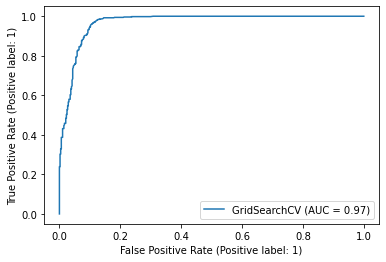

In [40]:
plot_roc_curve(gs, X_test, y_test)
plt.savefig("../graphics/model_four_rf_roc_curve.jpg", bbox_inches="tight", dpi=100); #save as jpg;

### Coefficients

In [41]:
coef = gs.best_estimator_._final_estimator.feature_importances_ # get coefficients
features = gs.best_estimator_['vect'].get_feature_names() #get feature names
zipped = zip(coef, features) #zip them together
lst = list(zipped) #turn zip object into a list
coef_df = pd.DataFrame(lst) # turn list into a df

In [42]:
coef_df.sort_values(by=0, ascending=False).head(10)

,0,1
11418,0.034810,running
11405,0.028735,run
13866,0.027476,ultra
10661,0.023744,race
13592,0.017393,training
2156,0.016869,backpacking
13721,0.009141,trip
895,0.009127,50k
8649,0.007871,miles
11425,0.007752,runs


In [43]:
top_ten_pos_class = coef_df.sort_values(by=0, ascending=True).tail(10)
top_ten_pos_class

,0,1
11425,0.007752,runs
8649,0.007871,miles
895,0.009127,50k
13721,0.009141,trip
2156,0.016869,backpacking
13592,0.017393,training
10661,0.023744,race
13866,0.027476,ultra
11405,0.028735,run
11418,0.034810,running


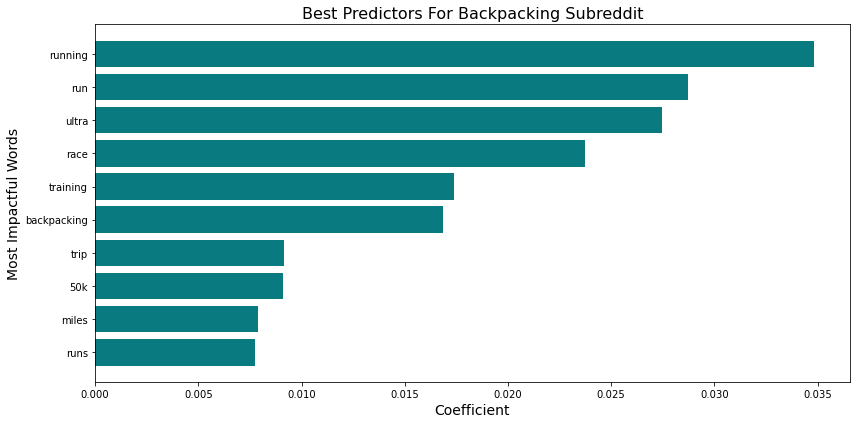

In [44]:
plt.figure(figsize=(12,6))
best_pred_sust = top_ten_pos_class.sort_values(by=0, ascending=False).head(15)
best_pred_sust = top_ten_pos_class.sort_values(by=0, ascending=True).tail(15)
x = best_pred_sust[1]
y = best_pred_sust[0]
plt.barh(x,y, color = '#097a80')
plt.xlabel('Coefficient', fontdict= {'fontsize':14})
plt.ylabel('Most Impactful Words', fontdict= {'fontsize':14})
plt.title('Best Predictors For Backpacking Subreddit', fontdict = {'fontsize':16})
plt.tight_layout()
plt.savefig("../graphics/model_four_rf_Top10_backpacking_coef.jpg", bbox_inches="tight", dpi=100); #save as jpg;

In [45]:
top_ten_neg_class = coef_df.sort_values(by=0, ascending=False).head(10)
top_ten_neg_class

,0,1
11418,0.034810,running
11405,0.028735,run
13866,0.027476,ultra
10661,0.023744,race
13592,0.017393,training
2156,0.016869,backpacking
13721,0.009141,trip
895,0.009127,50k
8649,0.007871,miles
11425,0.007752,runs


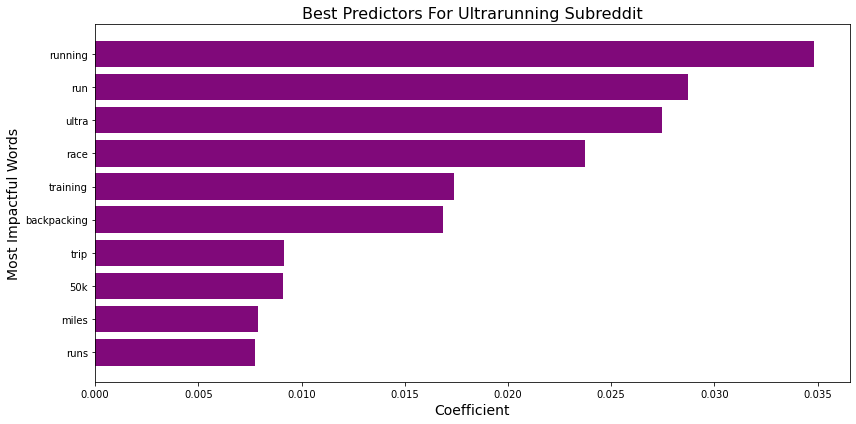

In [46]:
plt.figure(figsize=(12,6))
best_pred_sust = top_ten_neg_class.sort_values(by=0, ascending=False).head(15)
best_pred_sust = top_ten_neg_class.sort_values(by=0, ascending=True).tail(15)
x = best_pred_sust[1]
y = best_pred_sust[0]
plt.barh(x,y, color = '#80097a')
plt.xlabel('Coefficient', fontdict= {'fontsize':14})
plt.ylabel('Most Impactful Words', fontdict= {'fontsize':14})
plt.title('Best Predictors For Ultrarunning Subreddit', fontdict = {'fontsize':16})
plt.tight_layout()
plt.savefig("../graphics/model_four_rf_Top10_ultrarunning_coef.jpg", bbox_inches="tight", dpi=100); #save as jpg;